In [1]:
#install sqlite
#pip install sqlite-database


Note: you may need to restart the kernel to use updated packages.


In [3]:
#import libraries
import sqlite3
import csv
import numpy as np
import pandas as pd

syntax: sqlite3.connect(database, timeout=5.0, detect_types=0, isolation_level='DEFERRED', check_same_thread=True, factory=sqlite3.Connection, cached_statements=128, uri=False,*, autocommit=sqlite3.LEGACY_TRANSACTION_CONTROL)

# Data Description

## Coronavirus (Covid-19) Data in the United States (Archived)

Last Updated: March 24, 2023

Source: The New York Times (https://github.com/nytimes/covid-19-data)

Description:

This dataset provides cumulative COVID-19 cases and deaths from 2020 to 2023 in the U.S. at the U.S., state, and county levels. Data is from state and local health departments. It includes daily counts and covers both confirmed and probable cases.

License:ttribute to "The New York Times."

In [5]:
df_covid = pd.read_csv('/Users/bayowaonabajo/Downloads/archive-4/us-counties-recent.csv')
df_covid.head()

,date,county,state,fips,cases,deaths
0,2023-02-22,Autauga,Alabama,1001.0,19732,230.0
1,2023-02-22,Baldwin,Alabama,1003.0,69641,724.0
2,2023-02-22,Barbour,Alabama,1005.0,7451,112.0
3,2023-02-22,Bibb,Alabama,1007.0,8067,109.0
4,2023-02-22,Blount,Alabama,1009.0,18616,261.0


In [7]:

# Create a connection and db
# Syntax: conn = sqlite3.connect('databaseName.sqlite')
conn = sqlite3.connect('us_covid_recent_counties.db')

# Create a cursor object to navigate
cur = conn.cursor()

None is NULL
int is INTEGER
float is REAL
str is TEXT
bytes is BLOB

CREATE TABLE students(
name TEXT, 
age INTEGER,
grade INTEGER
);

In [9]:
# Create a table and cursor to interact with the database.
cur.execute('''DROP TABLE covid_data_''')

In [11]:
cur.execute( '''CREATE TABLE covid_data_ (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT,
        county TEXT,
        state TEXT,
        fips INTEGER,
        cases INTEGER,
        deaths REAL,
        country TEXT,
        year INTEGER
    )
''')

In [13]:
# utilizing the ny-times covid dataset showing covid case and death counts for U.S. counties 
data = "/Users/bayowaonabajo/Downloads/archive-4/us-counties-recent.csv"

# Open the file and read the data
with open(data, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # Skip the header row

    for row in csv_reader:
        date = row[0]
        county = row[1]
        state = row[2]
        fips_str = row[3]
        deaths_str = row[5]  

        # Check if fips is empty
        if fips_str == '':
            continue  # Skip row

        # Check if empty
        if deaths_str == '':
            continue  # Skip row

        fips = int(fips_str)
        cases = int(row[4])
        deaths = float(deaths_str)
        
        country = "U.S.A"
        
        year = int(date.split('-')[0])
        
        cur.execute('''
            INSERT INTO covid_data_ (date, county, state, fips, cases, deaths, country, year)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (date, county, state, fips, cases, deaths, country, year))

    conn.commit()



In [15]:
# Load dataFrame data into a SQLite Table
df_covid.to_sql('covid_data_', conn, if_exists='append', index=False)

97701

In [19]:
# Create 2nd table and a cursor to interact with the database.
cur.execute( '''CREATE TABLE state_summary (
    state TEXT PRIMARY KEY,
    total_cases INTEGER,
    total_deaths INTEGER
    )
''')

In [23]:
state_summary = df_covid.groupby('state').agg({'cases': 'sum', 'deaths': 'sum'}).reset_index()
state_summary.rename(columns={'cases': 'total_cases', 'deaths': 'total_deaths'}, inplace=True) 
state_summary.to_sql('state_summary', conn, if_exists='append', index=False)

56

In [25]:
# Perform Join
join_query = '''
SELECT 
    cd.county,
    cd.cases,
    ss.total_cases,
    ss.total_deaths,
    cd.state
FROM covid_data_ cd
JOIN state_summary ss ON cd.state = ss.state
LIMIT 10
'''


In [27]:
join_result = pd.read_sql_query(join_query, conn)
join_result

,county,cases,total_cases,total_deaths,state
0,Autauga,19732,49296332,645929,Alabama
1,Baldwin,69641,49296332,645929,Alabama
2,Barbour,7451,49296332,645929,Alabama
3,Bibb,8067,49296332,645929,Alabama
4,Blount,18616,49296332,645929,Alabama
5,Bullock,3020,49296332,645929,Alabama
6,Butler,6518,49296332,645929,Alabama
7,Calhoun,41228,49296332,645929,Alabama
8,Chambers,10812,49296332,645929,Alabama
9,Cherokee,6732,49296332,645929,Alabama


In [55]:
# Query 1, total cases and deaths per state
query_total_cases_death = '''
SELECT 
    state, 
    total_cases, 
    total_deaths
FROM state_summary
ORDER BY total_cases DESC
'''
agg_total = pd.read_sql_query(query_total_cases_death, conn)
agg_total.head()

,state,total_cases,total_deaths
0,California,363627975,3113790
1,Texas,250993695,2827300
2,Florida,225495192,2602533
3,New York,203624148,2392427
4,Illinois,122541831,1244190


In [31]:
# Query 2, counties with more than 50,000 cases 
query_high_cases = '''
SELECT county, state, cases
FROM covid_data_
WHERE cases > 50000
ORDER BY cases DESC
'''
high_cases_result = pd.read_sql_query(query_high_cases, conn)
high_cases_result.head()

,county,state,cases
0,Los Angeles,California,3723182
1,Los Angeles,California,3723182
2,Los Angeles,California,3722448
3,Los Angeles,California,3722448
4,Los Angeles,California,3721923


In [33]:
#Remove null values
cur.execute('''
DELETE FROM covid_data_
WHERE date IS NULL OR county IS NULL OR state IS NULL OR fips IS NULL 
   OR cases IS NULL OR deaths IS NULL OR country IS NULL OR year IS NULL
''')
conn.commit()

In [35]:
#Remove null values
cur.execute('''
DELETE FROM state_summary
WHERE state IS NULL OR total_cases IS NULL OR total_deaths IS NULL
''')
conn.commit()

In [45]:
cur.execute('''
SELECT * FROM state_summary
     WHERE state IS NULL OR total_cases IS NULL;
''')

cur.fetchall()

[]

In [41]:
cur.execute('''
INSERT INTO state_summary (state, total_cases, total_deaths)
VALUES ('Howard', 2000, 90) 
''')
conn.commit()

In [49]:
cur.execute('''
SELECT state,total_cases
     FROM state_summary
     WHERE total_cases = 2000;
''')

cur.fetchall()

[('Howard', 2000)]

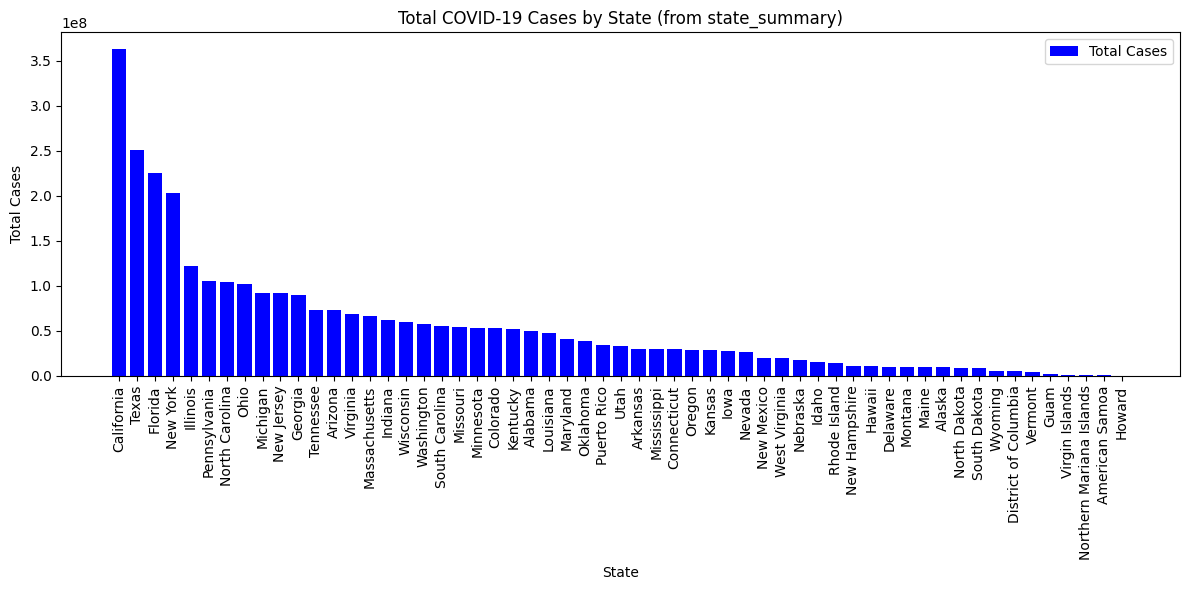

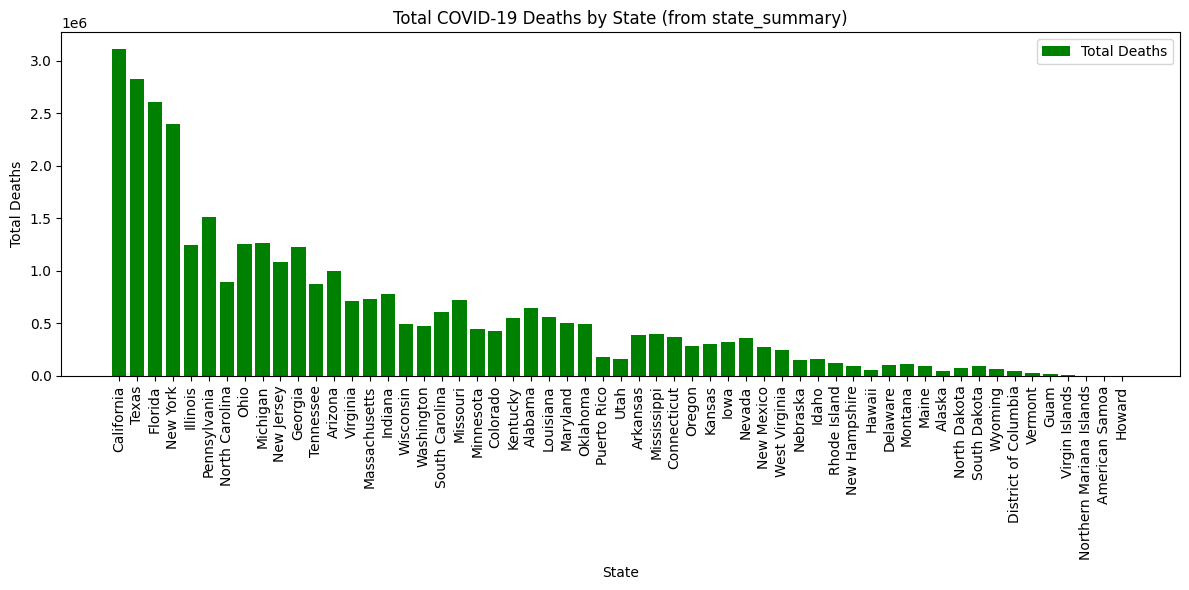

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(agg_total['state'], agg_total['total_cases'], color='blue', label='Total Cases')
plt.xlabel('State')
plt.ylabel('Total Cases')
plt.title('Total COVID-19 Cases by State (from state_summary)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(agg_total['state'], agg_total['total_deaths'], color='green', label='Total Deaths')
plt.xlabel('State')
plt.ylabel('Total Deaths')
plt.title('Total COVID-19 Deaths by State (from state_summary)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()



In [31]:
cur.execute('''
SELECT *
FROM covid_data_;''')

Nycoviddata = pd.DataFrame(cur.fetchall())
Nycoviddata.head()

,0,1,2,3,4,5,6,7,8
0,1,2023-02-22,Autauga,Alabama,1001,19732,230.0,U.S.A,2023
1,2,2023-02-22,Baldwin,Alabama,1003,69641,724.0,U.S.A,2023
2,3,2023-02-22,Barbour,Alabama,1005,7451,112.0,U.S.A,2023
3,4,2023-02-22,Bibb,Alabama,1007,8067,109.0,U.S.A,2023
4,5,2023-02-22,Blount,Alabama,1009,18616,261.0,U.S.A,2023


In [17]:
#First two states in the database
cur.execute('''
SELECT DISTINCT state
     FROM covid_data_
     ORDER BY state ASC
     LIMIT 2;
''')

cur.fetchall()

[('Alabama',), ('Alaska',)]

In [19]:
#Last two states in the database
cur.execute('''
SELECT DISTINCT state
     FROM covid_data_
     ORDER BY state DESC
     LIMIT 2;
''')

cur.fetchall()




[('Wyoming',), ('Wisconsin',)]

In [23]:
cur.execute('''
DELETE 
FROM covid_data_ WHERE id > 15;
''')

cur.execute('''
SELECT *
FROM covid_data_;
''')

cur.fetchall()

[(1, '2023-02-22', 'Autauga', 'Alabama', 1001, 19732, 230.0, 'U.S.A', 2023),
 (2, '2023-02-22', 'Baldwin', 'Alabama', 1003, 69641, 724.0, 'U.S.A', 2023),
 (3, '2023-02-22', 'Barbour', 'Alabama', 1005, 7451, 112.0, 'U.S.A', 2023),
 (4, '2023-02-22', 'Bibb', 'Alabama', 1007, 8067, 109.0, 'U.S.A', 2023),
 (5, '2023-02-22', 'Blount', 'Alabama', 1009, 18616, 261.0, 'U.S.A', 2023),
 (6, '2023-02-22', 'Bullock', 'Alabama', 1011, 3020, 54.0, 'U.S.A', 2023),
 (7, '2023-02-22', 'Butler', 'Alabama', 1013, 6518, 132.0, 'U.S.A', 2023),
 (8, '2023-02-22', 'Calhoun', 'Alabama', 1015, 41228, 675.0, 'U.S.A', 2023),
 (9, '2023-02-22', 'Chambers', 'Alabama', 1017, 10812, 176.0, 'U.S.A', 2023),
 (10, '2023-02-22', 'Cherokee', 'Alabama', 1019, 6732, 134.0, 'U.S.A', 2023),
 (11, '2023-02-22', 'Chilton', 'Alabama', 1021, 12956, 225.0, 'U.S.A', 2023),
 (12, '2023-02-22', 'Choctaw', 'Alabama', 1023, 2255, 63.0, 'U.S.A', 2023),
 (13, '2023-02-22', 'Clarke', 'Alabama', 1025, 8529, 114.0, 'U.S.A', 2023),
 (14, '2

In [97]:
#Earliest and Latest record date

cur.execute("SELECT MIN(date) AS earliest_date FROM covid_data_;")
earliest_date = cur.fetchall()
print("Earliest date:", earliest_date)


cur.execute("SELECT MAX(date) AS latest_date FROM covid_data_;")
latest_date = cur.fetchall()
print("Latest date:", latest_date)

Earliest date: [('2023-02-22',)]
Latest date: [('2023-03-23',)]


In [25]:
# SELECT first 100 rows
cur.execute('''
SELECT *
    FROM covid_data_ 
    LIMIT 20;
''')

cur.fetchall()

[(1, '2023-02-22', 'Autauga', 'Alabama', 1001, 19732, 230.0, 'U.S.A', 2023),
 (2, '2023-02-22', 'Baldwin', 'Alabama', 1003, 69641, 724.0, 'U.S.A', 2023),
 (3, '2023-02-22', 'Barbour', 'Alabama', 1005, 7451, 112.0, 'U.S.A', 2023),
 (4, '2023-02-22', 'Bibb', 'Alabama', 1007, 8067, 109.0, 'U.S.A', 2023),
 (5, '2023-02-22', 'Blount', 'Alabama', 1009, 18616, 261.0, 'U.S.A', 2023),
 (6, '2023-02-22', 'Bullock', 'Alabama', 1011, 3020, 54.0, 'U.S.A', 2023),
 (7, '2023-02-22', 'Butler', 'Alabama', 1013, 6518, 132.0, 'U.S.A', 2023),
 (8, '2023-02-22', 'Calhoun', 'Alabama', 1015, 41228, 675.0, 'U.S.A', 2023),
 (9, '2023-02-22', 'Chambers', 'Alabama', 1017, 10812, 176.0, 'U.S.A', 2023),
 (10, '2023-02-22', 'Cherokee', 'Alabama', 1019, 6732, 134.0, 'U.S.A', 2023),
 (11, '2023-02-22', 'Chilton', 'Alabama', 1021, 12956, 225.0, 'U.S.A', 2023),
 (12, '2023-02-22', 'Choctaw', 'Alabama', 1023, 2255, 63.0, 'U.S.A', 2023),
 (13, '2023-02-22', 'Clarke', 'Alabama', 1025, 8529, 114.0, 'U.S.A', 2023),
 (14, '2

In [27]:
# Select variables specific for date "2023-03-23"
cur.execute('''
SELECT *
    FROM covid_data_
    WHERE 2023-03-23;
''')

cur.fetchall()

[(1, '2023-02-22', 'Autauga', 'Alabama', 1001, 19732, 230.0, 'U.S.A', 2023),
 (2, '2023-02-22', 'Baldwin', 'Alabama', 1003, 69641, 724.0, 'U.S.A', 2023),
 (3, '2023-02-22', 'Barbour', 'Alabama', 1005, 7451, 112.0, 'U.S.A', 2023),
 (4, '2023-02-22', 'Bibb', 'Alabama', 1007, 8067, 109.0, 'U.S.A', 2023),
 (5, '2023-02-22', 'Blount', 'Alabama', 1009, 18616, 261.0, 'U.S.A', 2023),
 (6, '2023-02-22', 'Bullock', 'Alabama', 1011, 3020, 54.0, 'U.S.A', 2023),
 (7, '2023-02-22', 'Butler', 'Alabama', 1013, 6518, 132.0, 'U.S.A', 2023),
 (8, '2023-02-22', 'Calhoun', 'Alabama', 1015, 41228, 675.0, 'U.S.A', 2023),
 (9, '2023-02-22', 'Chambers', 'Alabama', 1017, 10812, 176.0, 'U.S.A', 2023),
 (10, '2023-02-22', 'Cherokee', 'Alabama', 1019, 6732, 134.0, 'U.S.A', 2023),
 (11, '2023-02-22', 'Chilton', 'Alabama', 1021, 12956, 225.0, 'U.S.A', 2023),
 (12, '2023-02-22', 'Choctaw', 'Alabama', 1023, 2255, 63.0, 'U.S.A', 2023),
 (13, '2023-02-22', 'Clarke', 'Alabama', 1025, 8529, 114.0, 'U.S.A', 2023),
 (14, '2